# Titers for a serum
Analyze titers for a serum, aggregating replicates which may be across multiple plates.

In [1]:
import pickle

import altair as alt

import neutcurve

import pandas as pd

_ = alt.data_transformers.disable_max_rows()

Get variables from `snakemake`:

In [2]:
######## snakemake preamble start (automatically inserted, do not edit) ########
import sys; sys.path.extend(['/Users/jbloom/miniconda3/envs/seqneut-pipeline/lib/python3.11/site-packages', '/Users/jbloom/Library/Caches/snakemake/snakemake/source-cache/runtime-cache/tmp58o4okjf/file/Users/jbloom/Library/CloudStorage/OneDrive-FredHutchinsonCancerCenter/seqneut-pipeline/notebooks', '/Users/jbloom/Library/CloudStorage/OneDrive-FredHutchinsonCancerCenter/seqneut-pipeline/notebooks']); import pickle; snakemake = pickle.loads(b"\x80\x04\x95\x8a\x12\x00\x00\x00\x00\x00\x00\x8c\x10snakemake.script\x94\x8c\tSnakemake\x94\x93\x94)\x81\x94}\x94(\x8c\x05input\x94\x8c\x0csnakemake.io\x94\x8c\nInputFiles\x94\x93\x94)\x81\x94(\x8c$results/plates/plate11/curvefits.csv\x94\x8c#results/plates/plate2/curvefits.csv\x94\x8c'results/plates/plate11/curvefits.pickle\x94\x8c&results/plates/plate2/curvefits.pickle\x94e}\x94(\x8c\x06_names\x94}\x94(\x8c\nplate_fits\x94K\x00K\x02\x86\x94\x8c\x07pickles\x94K\x02K\x04\x86\x94u\x8c\x12_allowed_overrides\x94]\x94(\x8c\x05index\x94\x8c\x04sort\x94eh\x17\x8c\tfunctools\x94\x8c\x07partial\x94\x93\x94h\x06\x8c\x19Namedlist._used_attribute\x94\x93\x94\x85\x94R\x94(h\x1d)}\x94\x8c\x05_name\x94h\x17sNt\x94bh\x18h\x1bh\x1d\x85\x94R\x94(h\x1d)}\x94h!h\x18sNt\x94bh\x11h\x06\x8c\tNamedlist\x94\x93\x94)\x81\x94(h\nh\x0be}\x94(h\x0f}\x94h\x15]\x94(h\x17h\x18eh\x17h\x1bh\x1d\x85\x94R\x94(h\x1d)}\x94h!h\x17sNt\x94bh\x18h\x1bh\x1d\x85\x94R\x94(h\x1d)}\x94h!h\x18sNt\x94bubh\x13h()\x81\x94(h\x0ch\re}\x94(h\x0f}\x94h\x15]\x94(h\x17h\x18eh\x17h\x1bh\x1d\x85\x94R\x94(h\x1d)}\x94h!h\x17sNt\x94bh\x18h\x1bh\x1d\x85\x94R\x94(h\x1d)}\x94h!h\x18sNt\x94bubub\x8c\x06output\x94h\x06\x8c\x0bOutputFiles\x94\x93\x94)\x81\x94(\x8c,results/sera/M099d0/titers_per_replicate.csv\x94\x8c%results/sera/M099d0/titers_median.csv\x94\x8c\x1eresults/sera/M099d0/curves.pdf\x94\x8c#results/sera/M099d0/qc_failures.txt\x94e}\x94(h\x0f}\x94(\x8c\x0eper_rep_titers\x94K\x00N\x86\x94\x8c\rmedian_titers\x94K\x01N\x86\x94\x8c\ncurves_pdf\x94K\x02N\x86\x94\x8c\x0bqc_failures\x94K\x03N\x86\x94uh\x15]\x94(h\x17h\x18eh\x17h\x1bh\x1d\x85\x94R\x94(h\x1d)}\x94h!h\x17sNt\x94bh\x18h\x1bh\x1d\x85\x94R\x94(h\x1d)}\x94h!h\x18sNt\x94bhKhEhMhFhOhGhQhHub\x8c\x06params\x94h\x06\x8c\x06Params\x94\x93\x94)\x81\x94(]\x94(\x8c\x14A/California/07/2009\x94\x8c\x12A/Michigan/45/2015\x94\x8c\x12A/Brisbane/02/2018\x94\x8c\x11A/Ghana/2080/2020\x94\x8c\x18A/Cote_DIvoire/1448/2021\x94\x8c\x10A/Ghana/138/2020\x94\x8c\x0fA/Togo/845/2020\x94\x8c\x10A/Togo/0274/2021\x94\x8c\x10A/Hawaii/70/2019\x94\x8c\x12A/Niger/10217/2021\x94\x8c\x19A/SouthAfrica/R16462/2021\x94\x8c\x10A/Togo/0304/2021\x94\x8c\x12A/Paris/31196/2021\x94\x8c\x14A/Belgium/H0017/2022\x94\x8c\x18A/England/220200318/2022\x94\x8c\x12A/Paris/30353/2021\x94\x8c\x10A/Nimes/871/2021\x94\x8c\x14A/Belgium/H0038/2022\x94\x8c\x14A/Wisconsin/588/2019\x94\x8c\x14A/Washington/23/2020\x94\x8c\x1aA/India/Pun-NIV312851/2021\x94\x8c\x1aA/India-PUN-NIV328484/2021\x94\x8c\x16A/Bangladesh/8036/2021\x94\x8c\x0eA/Perth/1/2022\x94\x8c\x19A/SouthAfrica/R14850/2021\x94\x8c\x13A/Norway/25089/2022\x94\x8c\x1cA/Bangladesh/3210810034/2021\x94\x8c\x13A/Chester/5355/2022\x94\x8c\x12A/Michigan/19/2021\x94\x8c\x0eA/Utah/27/2022\x94\x8c\x12A/Newcastle/2/2022\x94\x8c\x1fA/India-Pune-Nivcov2221170/2022\x94\x8c\x10A/Sydney/43/2022\x94\x8c\x12A/Brisbane/48/2022\x94\x8c\x16A/Bangladesh/8002/2021\x94\x8c\x16A/Bangladesh/2221/2021\x94e}\x94(\x8c\x0emin_replicates\x94K\x02\x8c\x1bmax_fold_change_from_median\x94K\x03u}\x94(\x8c\x16A/Bangladesh/8002/2021\x94}\x94\x8c\tignore_qc\x94\x88s\x8c\x12A/Brisbane/02/2018\x94}\x94\x8c\tignore_qc\x94\x88s\x8c\x13A/Norway/25089/2022\x94}\x94\x8c\x12replicates_to_drop\x94]\x94\x8c\x18plate11-CGGATAAAAATGATAT\x94as\x8c\x14A/Wisconsin/588/2019\x94}\x94\x8c\x12replicates_to_drop\x94]\x94\x8c\x18plate11-AGTCCTATCCTCAAAT\x94asue}\x94(h\x0f}\x94(\x8c\x17viral_strain_plot_order\x94K\x00N\x86\x94\x8c\rqc_thresholds\x94K\x01N\x86\x94\x8c\rqc_exclusions\x94K\x02N\x86\x94uh\x15]\x94(h\x17h\x18eh\x17h\x1bh\x1d\x85\x94R\x94(h\x1d)}\x94h!h\x17sNt\x94bh\x18h\x1bh\x1d\x85\x94R\x94(h\x1d)}\x94h!h\x18sNt\x94bh\x9bh`h\x9dh\x85h\x9fh\x88ub\x8c\twildcards\x94h\x06\x8c\tWildcards\x94\x93\x94)\x81\x94\x8c\x06M099d0\x94a}\x94(h\x0f}\x94\x8c\x05serum\x94K\x00N\x86\x94sh\x15]\x94(h\x17h\x18eh\x17h\x1bh\x1d\x85\x94R\x94(h\x1d)}\x94h!h\x17sNt\x94bh\x18h\x1bh\x1d\x85\x94R\x94(h\x1d)}\x94h!h\x18sNt\x94b\x8c\x05serum\x94h\xaeub\x8c\x07threads\x94K\x01\x8c\tresources\x94h\x06\x8c\tResources\x94\x93\x94)\x81\x94(K\x01K\x01\x8c0/var/folders/jj/t2kjg1p146x_z68z7j80z8yw0000gq/T\x94e}\x94(h\x0f}\x94(\x8c\x06_cores\x94K\x00N\x86\x94\x8c\x06_nodes\x94K\x01N\x86\x94\x8c\x06tmpdir\x94K\x02N\x86\x94uh\x15]\x94(h\x17h\x18eh\x17h\x1bh\x1d\x85\x94R\x94(h\x1d)}\x94h!h\x17sNt\x94bh\x18h\x1bh\x1d\x85\x94R\x94(h\x1d)}\x94h!h\x18sNt\x94bh\xc5K\x01h\xc7K\x01h\xc9h\xc2ub\x8c\x03log\x94h\x06\x8c\x03Log\x94\x93\x94)\x81\x94\x8c-results/sera/M099d0/serum_titers_M099d0.ipynb\x94a}\x94(h\x0f}\x94\x8c\x08notebook\x94K\x00N\x86\x94sh\x15]\x94(h\x17h\x18eh\x17h\x1bh\x1d\x85\x94R\x94(h\x1d)}\x94h!h\x17sNt\x94bh\x18h\x1bh\x1d\x85\x94R\x94(h\x1d)}\x94h!h\x18sNt\x94bh\xdbh\xd8ub\x8c\x06config\x94}\x94(\x8c\x10seqneut-pipeline\x94\x8c\x03../\x94\x8c\x0fviral_libraries\x94}\x94\x8c\x14pdmH1N1_lib2023_loes\x94\x8c-data/viral_libraries/pdmH1N1_lib2023_loes.csv\x94s\x8c\x17viral_strain_plot_order\x94\x8c data/viral_strain_plot_order.csv\x94\x8c\x12neut_standard_sets\x94}\x94\x8c\x08loes2023\x94\x8c3data/neut_standard_sets/loes2023_neut_standards.csv\x94s\x8c\x1eillumina_barcode_parser_params\x94}\x94(\x8c\x08upstream\x94\x8c\x1fCTCCCTACAATGTCGGATTTGTATTTAATAG\x94\x8c\ndownstream\x94\x8c\x00\x94\x8c\x04minq\x94K\x14\x8c\x11upstream_mismatch\x94K\x04\x8c\x0ebc_orientation\x94\x8c\x02R2\x94u\x8c$default_process_counts_qc_thresholds\x94}\x94(\x8c\x12avg_barcode_counts\x94K\xfa\x8c\x16min_neut_standard_frac\x94G?tz\xe1G\xae\x14{\x8c\x1fmax_neut_standard_frac_no_serum\x94G?\xb9\x99\x99\x99\x99\x99\x9a\x8c\x18barcode_frac_consistency\x94K\x04\x8c\x16min_viral_barcode_frac\x94G?@bM\xd2\xf1\xa9\xfc\x8c\x1emin_neut_standard_barcode_frac\x94G?tz\xe1G\xae\x14{\x8c\x17min_neut_standard_count\x94M^\x01\x8c min_no_serum_viral_barcode_count\x94K\x05\x8c!min_dilutions_per_serum_replicate\x94K\x04\x8c\x14max_frac_infectivity\x94K\x08u\x8c\x17default_curvefit_params\x94}\x94(\x8c\x18frac_infectivity_ceiling\x94K\x01\x8c\x06fixtop\x94\x89\x8c\tfixbottom\x94K\x00u\x8c\x06plates\x94}\x94(\x8c\x06plate2\x94}\x94(\x8c\x04date\x94\x8c\x08datetime\x94\x8c\x04date\x94\x93\x94C\x04\x07\xe7\x08\x01\x94\x85\x94R\x94\x8c\rviral_library\x94\x8c\x14pdmH1N1_lib2023_loes\x94\x8c\x11neut_standard_set\x94\x8c\x08loes2023\x94\x8c\x0bsamples_csv\x94\x8c\x1edata/plates/plate2_samples.csv\x94\x8c\x1cprocess_counts_qc_thresholds\x94}\x94(j\x00\x01\x00\x00K\xfaj\x01\x01\x00\x00G?tz\xe1G\xae\x14{j\x02\x01\x00\x00G?\xb9\x99\x99\x99\x99\x99\x9aj\x03\x01\x00\x00K\x04j\x04\x01\x00\x00G?@bM\xd2\xf1\xa9\xfcj\x05\x01\x00\x00G?tz\xe1G\xae\x14{j\x06\x01\x00\x00M^\x01j\x07\x01\x00\x00K\x05j\x08\x01\x00\x00K\x04j\t\x01\x00\x00K\x08u\x8c\x10barcodes_to_drop\x94]\x94\x8c\x10GGTCCATCTCAGATCG\x94a\x8c\rwells_to_drop\x94]\x94(\x8c\x02C1\x94\x8c\x03D12\x94e\x8c\x0fcurvefit_params\x94}\x94(j\x0c\x01\x00\x00K\x01j\r\x01\x00\x00\x89j\x0e\x01\x00\x00K\x00uu\x8c\x07plate11\x94}\x94(\x8c\x04date\x94j\x16\x01\x00\x00C\x04\x07\xe7\t\x1a\x94\x85\x94R\x94\x8c\rviral_library\x94\x8c\x14pdmH1N1_lib2023_loes\x94\x8c\x11neut_standard_set\x94\x8c\x08loes2023\x94\x8c\x0bsamples_csv\x94\x8c\x1fdata/plates/plate11_samples.csv\x94\x8c\x1cprocess_counts_qc_thresholds\x94}\x94(j\x00\x01\x00\x00K\xfaj\x01\x01\x00\x00G?tz\xe1G\xae\x14{j\x02\x01\x00\x00G?\xb9\x99\x99\x99\x99\x99\x9aj\x03\x01\x00\x00K\x04j\x04\x01\x00\x00G?@bM\xd2\xf1\xa9\xfcj\x05\x01\x00\x00G?tz\xe1G\xae\x14{j\x06\x01\x00\x00M^\x01j\x07\x01\x00\x00K\x05j\x08\x01\x00\x00K\x04j\t\x01\x00\x00K\x08u\x8c\x10barcodes_to_drop\x94]\x94\x8c\x10GGTCCATCTCAGATCG\x94a\x8c\rwells_to_drop\x94]\x94(\x8c\x02D6\x94\x8c\x03C12\x94e\x8c\x0fcurvefit_params\x94}\x94(j\x0c\x01\x00\x00K\x01j\r\x01\x00\x00\x89j\x0e\x01\x00\x00K\x00uuu\x8c\x1aserum_titers_qc_thresholds\x94h\x85\x8c\x1aserum_titers_qc_exclusions\x94}\x94\x8c\x06M099d0\x94h\x88su\x8c\x04rule\x94\x8c\x0cserum_titers\x94\x8c\x0fbench_iteration\x94N\x8c\tscriptdir\x94\x8ca/Users/jbloom/Library/CloudStorage/OneDrive-FredHutchinsonCancerCenter/seqneut-pipeline/notebooks\x94ub."); from snakemake.logging import logger; logger.printshellcmds = False; import os; os.chdir(r'/Users/jbloom/Library/CloudStorage/OneDrive-FredHutchinsonCancerCenter/seqneut-pipeline/test_example');
######## snakemake preamble end #########

In [3]:
plate_fits = snakemake.input.plate_fits
pickle_fits = snakemake.input.pickles
viral_strain_plot_order = snakemake.params.viral_strain_plot_order
per_rep_titers_csv = snakemake.output.per_rep_titers
median_titers_csv = snakemake.output.median_titers
curves_pdf = snakemake.output.curves_pdf
serum = snakemake.wildcards.serum
qc_thresholds = snakemake.params.qc_thresholds
qc_exclusions = snakemake.params.qc_exclusions
qc_failures_file = snakemake.output.qc_failures

Process the QC exclusions:

In [4]:
print(f"The QC thresholds are:\n{qc_thresholds}")

# get viruses for which we are ignoring QC
viruses_ignore_qc = [
    virus
    for virus, d in qc_exclusions.items()
    if "ignore_qc" in d and d["ignore_qc"] is True
]
if viruses_ignore_qc:
    print("\nIgnoring QC for these viruses:\n\t" + "\n\t".join(viruses_ignore_qc))

# get virus replicates to drop
virus_replicates_to_drop = [
    (virus, rep)
    for virus, d in qc_exclusions.items()
    for rep in (d["replicates_to_drop"] if "replicates_to_drop" in d else [])
]
if virus_replicates_to_drop:
    print(
        "\nDropping these virus-replicates:\n\t"
        + "\n\t".join(str(tup) for tup in virus_replicates_to_drop)
    )

The QC thresholds are:
{'min_replicates': 2, 'max_fold_change_from_median': 3}

Ignoring QC for these viruses:
	A/Bangladesh/8002/2021
	A/Brisbane/02/2018

Dropping these virus-replicates:
	('A/Norway/25089/2022', 'plate11-CGGATAAAAATGATAT')
	('A/Wisconsin/588/2019', 'plate11-AGTCCTATCCTCAAAT')


Read all titers for this serum, dropping virus/replicates to drop:

In [5]:
print(f"Reading titers for {serum=}")

assert len(plate_fits)

serum_fits = (
    pd.concat([pd.read_csv(f) for f in plate_fits])
    .query("serum == @serum")
)

# remove virus-replicates to drop
print(f"Read a total of {len(serum_fits)} titers")
assert "tup" not in set(serum_fits.columns)
serum_fits = (
    serum_fits
    .assign(
        tup=lambda x: list(
            x[["virus", "replicate"]].itertuples(index=False, name=None)
        ),
    )
    .query("tup not in @virus_replicates_to_drop")
    .drop(columns="tup")
)
print(f"Retained {len(serum_fits)} titers after dropping specified ones")

assert len(serum_fits), f"no titers for {serum=}"
assert len(serum_fits) == len(serum_fits.groupby(["replicate", "virus"]))
print(f"Read a total of {len(serum_fits)} titers for {serum=}")

# get viruses in the order to plot them
viruses = sorted(serum_fits["virus"].unique())
if viral_strain_plot_order is not None:
    if not set(viruses).issubset(viral_strain_plot_order):
        raise ValueError(
            "`viral_strain_plot_order` lacks some viruses with titers:\n"
            + str(set(viruses) - set(viral_strain_plot_order))
        )
    viruses = [v for v in viral_strain_plot_order if v in viruses]
print(f"{serum=} has titers for a total of {len(viruses)} viruses")

Reading titers for serum='M099d0'
Read a total of 220 titers
Retained 218 titers after dropping specified ones
Read a total of 218 titers for serum='M099d0'
serum='M099d0' has titers for a total of 36 viruses


Get the NT50s per replicate.
Note that a lower bound in the IC50s represents and upper-bound on the NT50s:

In [6]:
per_rep_titers = (
    serum_fits
    .assign(
        nt50_bound=lambda x: x["ic50_bound"].map(
            {"interpolated": "interpolated", "upper": "lower", "lower": "upper"}
        ),
    )
    [["serum", "replicate", "virus", "nt50", "nt50_bound"]]
)

assert per_rep_titers.notnull().all().all()

print(f"Saving {len(per_rep_titers)} per-replicate titers to {per_rep_titers_csv}")
per_rep_titers.to_csv(per_rep_titers_csv, index=False, float_format="%.4g")

Saving 218 per-replicate titers to results/sera/M099d0/titers_per_replicate.csv


Get the median titers and the standard error of the mean. We defined the bounds (is the measurement interpolated or at a bound of the dilution series) for the median as the same as the bounds for the median measurement if there are an odd number of measurements, or if there are an even number of measurements interpolated only if all of the middle values are interpolated:

In [7]:
def get_median_nt50_bound(s):
    """Get the bound for the median NT50."""
    s = list(s)
    if len(s) % 2:
        return s[len(s) // 2]
    else:
        bounds = s[len(s) // 2 - 1: len(s) // 2 + 1]
        assert len(bounds) == 2
        if len(set(bounds)) == 1:
            return bounds[0]
        elif "interpolated" in bounds:
            return [b for b in bounds if b != "interpolated"][0]
        else:
            return "inconsistent"

median_titers = (
    per_rep_titers
    .sort_values("nt50")  # for getting median nt50 bound
    .groupby(["serum", "virus"], as_index=False)
    .aggregate(
        nt50=pd.NamedAgg("nt50", "median"),
        n_replicates=pd.NamedAgg("replicate", "count"),
        nt50_stderr=pd.NamedAgg("nt50", "sem"),
        nt50_bound=pd.NamedAgg("nt50_bound", get_median_nt50_bound),
    )
)

print(f"Saving {len(median_titers)} median titers to {median_titers_csv}")
median_titers.to_csv(median_titers_csv, index=False, float_format="%.4g")

Saving 36 median titers to results/sera/M099d0/titers_median.csv


Plot the per-replicate and median titers:

In [8]:
virus_selection = alt.selection_point(fields=["virus"], on="mouseover", empty=False)

per_rep_chart = (
    alt.Chart(per_rep_titers)
    .encode(
        alt.X("virus", sort=viruses),
        alt.Y(
            "nt50",
            title="neutralization titer",
            scale=alt.Scale(nice=False, padding=5, type="log"),
        ),
        alt.Shape("nt50_bound", title="is titer bound?"),
        strokeWidth=alt.condition(virus_selection, alt.value(2), alt.value(0)),
        tooltip=[
            alt.Tooltip(c, format=".3g") if per_rep_titers[c].dtype == float else c
            for c in per_rep_titers if c != "serum"
        ],
    )
    .mark_point(size=45, filled=True, fillOpacity=0.5, strokeOpacity=1, stroke="black", color="#56B4E9")
)

median_chart = (
    alt.Chart(median_titers)
    .encode(
        alt.X("virus", sort=viruses),
        alt.Y(
            "nt50",
            title="neutralization titer",
            scale=alt.Scale(nice=False, padding=5, type="log"),
        ),
        alt.Shape("nt50_bound", title="is titer bound?"),
        strokeWidth=alt.condition(virus_selection, alt.value(2), alt.value(0)),
        tooltip=[
            alt.Tooltip(c, format=".3g") if median_titers[c].dtype == float else c
            for c in median_titers if c != "serum"
        ],
    )
    .mark_point(color="#E69F00", size=85, filled=True, fillOpacity=0.9, strokeOpacity=1, stroke="black")
)

titer_chart = (
    (per_rep_chart + median_chart)
    .add_params(virus_selection)
    .properties(
        width=alt.Step(14),
        height=200,
        title=f"{serum} median (orange) and per-replicate (blue) titers",
    )
    .configure_axis(grid=False)
)

titer_chart 

alt.LayerChart(...)

Get any QC failures, and write to file:

In [9]:
qc_failures = []

insufficient_replicates = median_titers[
    median_titers["n_replicates"] < qc_thresholds["min_replicates"]
]
if len(insufficient_replicates):
    print(f"The following viruses fail {qc_thresholds['min_replicates']=}")
    display(insufficient_replicates)
    qc_failures.append("min_replicates")
else:
    print(f"All viruses pass {qc_thresholds['min_replicates']=}")

max_fold_change_from_median = qc_thresholds["max_fold_change_from_median"]
assert max_fold_change_from_median > 1, max_fold_change_from_median
excess_fold_change_from_median = (
    median_titers
    .rename(columns={"nt50": "median_nt50"})
    [["virus", "median_nt50"]]
    .merge(per_rep_titers, validate="one_to_many")
    .assign(
        fold_change_from_median=lambda x: x["nt50"] / x["median_nt50"],
        excess_fold_change=lambda x: (
            (x["fold_change_from_median"] > max_fold_change_from_median)
            | (x["fold_change_from_median"] < 1 / max_fold_change_from_median)
        ),
    )
    .query("excess_fold_change")
)
if len(excess_fold_change_from_median):
    print(f"\nThese replicates fail {qc_thresholds['max_fold_change_from_median']=}")
    display(excess_fold_change_from_median)
    qc_failures.append("max_fold_change_from_median")
else:
    print(f"\nAll viruses pass {qc_thresholds['max_fold_change_from_median']=}")

qc_failures = "\n".join(qc_failures)
if qc_failures:
    print(f"\nEncountered the following QC failures:\n{qc_failures}")
else:
    print("\nNo QC failures")
print(f"\nLogging QC failures to {qc_failures_file}")
with open(qc_failures_file, "w") as f:
    f.write(qc_failures)

All viruses pass qc_thresholds['min_replicates']=2

These replicates fail qc_thresholds['max_fold_change_from_median']=3


,virus,median_nt50,serum,replicate,nt50,nt50_bound,fold_change_from_median,excess_fold_change
12,A/Bangladesh/8002/2021,292.2,M099d0,plate11-TCTGCTAAACTAAGTA,909.5,interpolated,3.112594,True
34,A/Brisbane/02/2018,703.4,M099d0,plate11-ACGACATGATCAAACG,2642.0,interpolated,3.756042,True



Encountered the following QC failures:
max_fold_change_from_median

Logging QC failures to results/sera/M099d0/qc_failures.txt


Plot the individual neutralization curves:

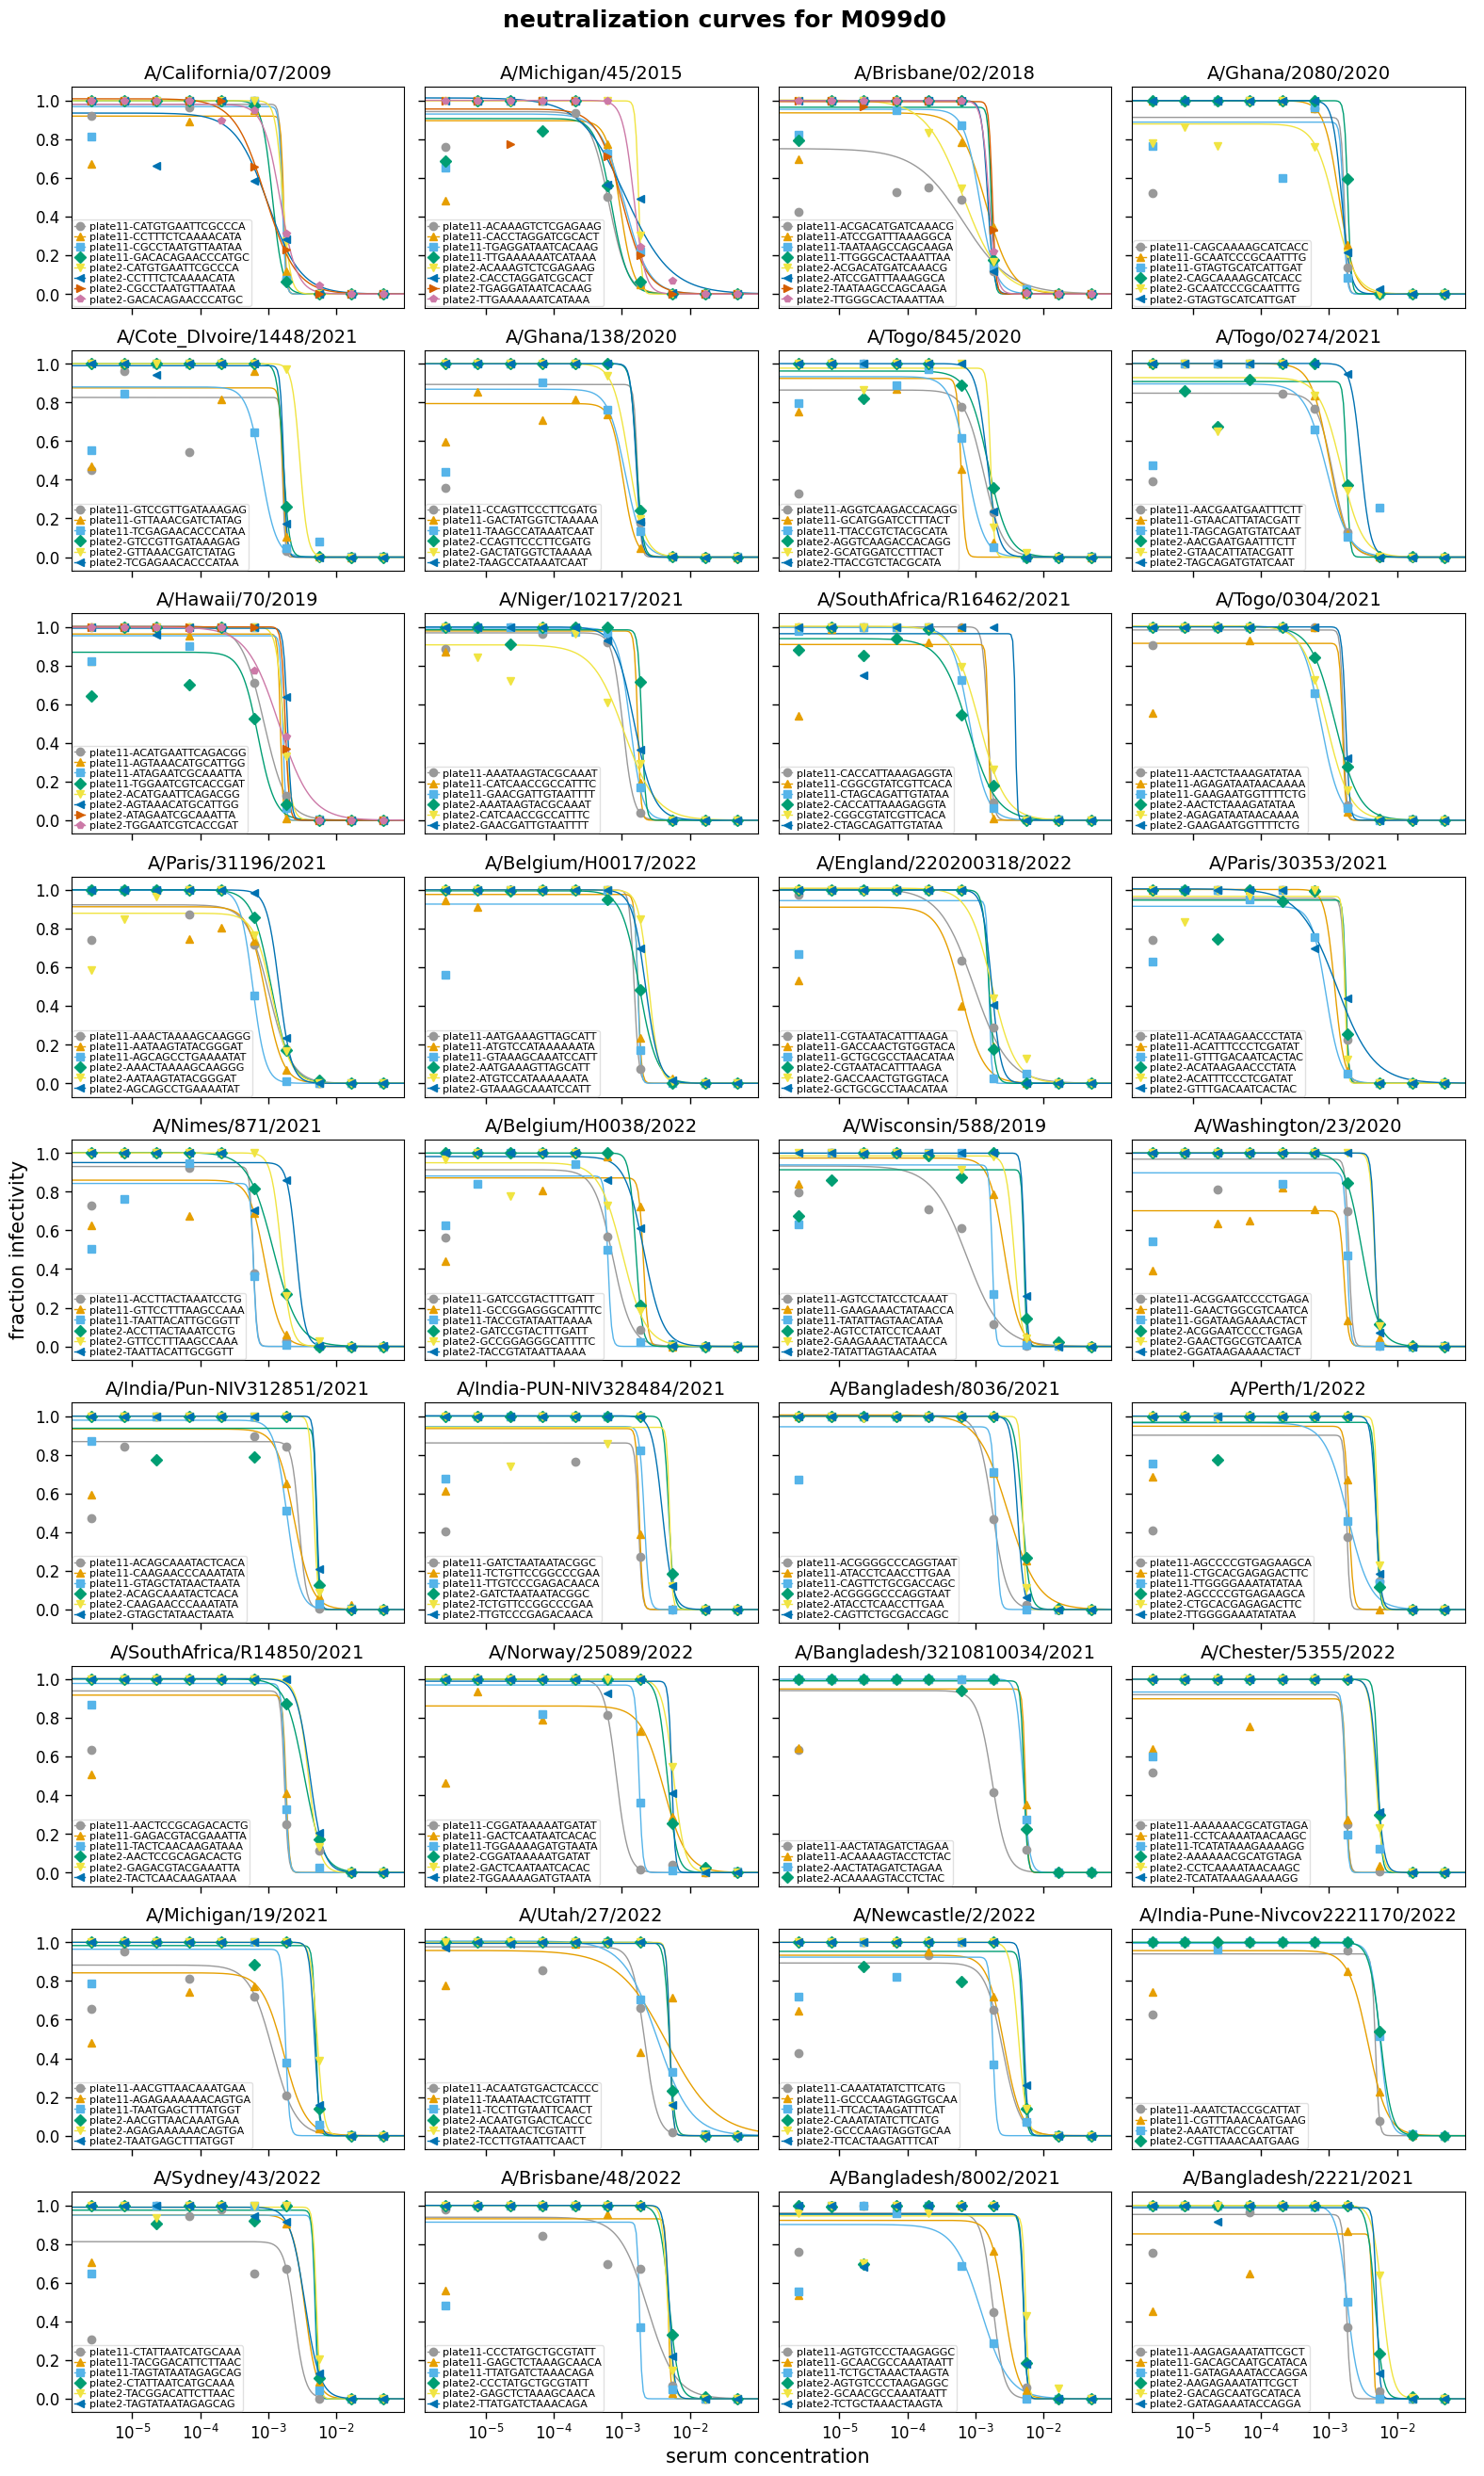

In [12]:
# combine all the fits
fits_to_combine = []
for fname in pickle_fits:
    with open(fname, "rb") as f:
        fits_to_combine.append(pickle.load(f))
serum_curvefits = neutcurve.CurveFits.combineCurveFits(
    fits_to_combine,
    sera=[serum],
    serum_virus_replicates_to_drop=[
        (serum, virus, replicate)
        for (virus, replicate) in virus_replicates_to_drop
    ],
)

fig, _ = serum_curvefits.plotReplicates(
    attempt_shared_legend=False,
    legendfontsize=8,
    ncol=4,
    heightscale=1.25,
    widthscale=1.25,
    viruses=viruses,
    subplot_titles="{virus}",
)

_ = fig.suptitle(f"neutralization curves for {serum}", y=1, fontsize=18, fontweight="bold")

fig.tight_layout()

Save the curves to a file:

In [11]:
print(f"Saving to {curves_pdf}")
fig.savefig(curves_pdf)

Saving to results/sera/M099d0/curves.pdf
